## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import tempfile  # 추가
import s3fs
from scipy.stats import shapiro, spearmanr, kruskal
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore')

## Load Data

In [2]:
s3 = s3fs.S3FileSystem()

months = [f"month={str(i).zfill(2)}" for i in range(1, 7)]
base_path = "s3://mlops-prj/data/weather/raw/year=2025"

all_files = []
for month in months:
    # 각 월의 모든 일(day) 폴더 찾기
    day_folders = s3.ls(f"{base_path}/{month}")
    for day_folder in day_folders:
        # 각 일(day) 폴더 안의 모든 parquet 파일 찾기
        files = s3.glob(f"{day_folder}/*.parquet")
        all_files.extend(files)

print("전체 파일 개수:", len(all_files))

df_list = [pd.read_parquet(file, filesystem=s3) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
df

전체 파일 개수: 156


,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,...,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,year,month,day
0,2025-01-01 00:00:00,108,29,0.7,-9,-9.0,-9,1011.6,1022.5,0,...,1.7,-9,-9.0,-9,3,2,0,2025,1,1
1,2025-01-01 01:00:00,108,25,1.1,-9,-9.0,-9,1011.7,1022.6,-9,...,1.7,-9,-9.0,-9,3,-9,1,2025,1,1
2,2025-01-01 02:00:00,108,34,0.5,-9,-9.0,-9,1011.5,1022.4,-9,...,1.7,-9,-9.0,-9,3,-9,2,2025,1,1
3,2025-01-01 03:00:00,108,2,1.9,-9,-9.0,-9,1011.3,1022.2,8,...,1.7,-9,-9.0,-9,3,2,3,2025,1,1
4,2025-01-01 04:00:00,108,2,2.2,-9,-9.0,-9,1010.8,1021.7,-9,...,1.7,-9,-9.0,-9,3,2,4,2025,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,2025-06-03 21:00:00,108,25,2.3,23,11.0,1511,990.5,1000.4,2,...,17.5,-9,-9.0,-9,3,2,21,2025,6,3
3694,2025-06-03 22:00:00,108,25,1.9,-9,-9.0,-9,991.2,1001.1,-9,...,17.7,-9,-9.0,-9,3,-9,22,2025,6,3
3695,2025-06-03 23:00:00,108,27,2.3,-9,-9.0,-9,991.3,1001.3,-9,...,20.8,-9,-9.0,-9,3,-9,23,2025,6,3
3696,2025-06-04 23:00:00,108,25,2.6,-9,-9.0,-9,998.1,1008.1,-9,...,18.2,-9,-9.0,-9,3,-9,23,2025,6,4


## Data Preprocessing

- Data Type Check
- Missing Value Check

In [3]:
df.describe()

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,GustSpeed,GustTime,LocalPressure,SeaLevelPressure,PressureTrend,...,SoilTemperature20cm,SoilTemperature30cm,SeaCondition,WaveHeight,MaxWindForce,PrecipitationData,ObservationType,hour,month,day
count,3698,3698.0,3698.000000,3698.000000,3698.000000,3698.000000,3698.000000,3698.000000,3698.000000,3698.000000,...,3698.000000,3698.000000,3698.0,3698.0,3698.0,3698.000000,3698.000000,3698.000000,3698.000000,3698.000000
mean,2025-03-19 00:31:05.224445952,108.0,19.835857,2.497323,-6.200108,-7.171714,112.565711,1006.246620,1016.735938,-4.615197,...,6.929475,6.906679,-9.0,-9.0,-9.0,3.095998,-0.099513,11.505679,3.073012,15.351271
min,2025-01-01 00:00:00,108.0,0.000000,0.000000,-9.000000,-9.000000,-9.000000,984.000000,993.700000,-9.000000,...,-1.700000,-0.700000,-9.0,-9.0,-9.0,1.000000,-9.000000,0.000000,1.000000,1.000000
25%,2025-02-08 12:15:00,108.0,7.000000,1.600000,-9.000000,-9.000000,-9.000000,999.900000,1010.100000,-9.000000,...,-0.300000,0.400000,-9.0,-9.0,-9.0,3.000000,1.000000,6.000000,2.000000,8.000000
50%,2025-03-19 00:30:00,108.0,25.000000,2.300000,-9.000000,-9.000000,-9.000000,1006.600000,1017.100000,-9.000000,...,6.500000,6.200000,-9.0,-9.0,-9.0,3.000000,2.000000,12.000000,3.000000,15.000000
75%,2025-04-26 12:45:00,108.0,27.000000,3.200000,-9.000000,-9.000000,-9.000000,1013.000000,1023.700000,2.000000,...,13.800000,13.400000,-9.0,-9.0,-9.0,3.000000,2.000000,18.000000,4.000000,23.000000
max,2025-06-05 21:00:00,108.0,36.000000,8.400000,36.000000,21.000000,2341.000000,1022.300000,1033.400000,8.000000,...,22.400000,20.800000,-9.0,-9.0,-9.0,4.000000,2.000000,23.000000,6.000000,31.000000
std,NaN,0.0,10.029351,1.246982,9.297795,5.874440,414.202701,8.156646,8.493493,6.384180,...,7.089657,6.508814,0.0,0.0,0.0,0.391594,4.006128,6.925594,1.470132,8.870613


### Data Type Check

In [4]:
# Data type check
def check_dtype(df, return_data=False):
    object_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(include=['number'])

    print(f"Object Data Type: {object_df.shape[1]}")
    print(f"Number Data Type: {num_df.shape[1]}")

    if return_data: # 데이터 프레임 할당
        return object_df, num_df

In [5]:
str_df, num_df = check_dtype(df, return_data=True)

Object Data Type: 2
Number Data Type: 46


In [6]:
num_df.columns

Index(['StationID', 'WindDirection', 'WindSpeed', 'GustDirection', 'GustSpeed',
       'GustTime', 'LocalPressure', 'SeaLevelPressure', 'PressureTrend',
       'PressureChange', 'Temperature', 'DewPointTemperature',
       'RelativeHumidity', 'VaporPressure', 'HourlyRainfall', 'DailyRainfall',
       'CumulativeRainfall', 'RainfallIntensity', 'SnowDepth3Hr',
       'DailySnowDepth', 'TotalSnowDepth', 'CurrentWeatherCode',
       'PastWeatherCode', 'TotalCloudCover', 'MidLowCloudCover',
       'LowestCloudHeight', 'UpperCloudType', 'MidCloudType', 'LowCloudType',
       'Visibility', 'SunshineDuration', 'SolarRadiation', 'GroundCondition',
       'GroundTemperature', 'SoilTemperature5cm', 'SoilTemperature10cm',
       'SoilTemperature20cm', 'SoilTemperature30cm', 'SeaCondition',
       'WaveHeight', 'MaxWindForce', 'PrecipitationData', 'ObservationType',
       'hour', 'month', 'day'],
      dtype='object')

In [7]:
# StationID 는 지점번호 를 의미 그래서 문자열로 변경
df['StationID'] = df['StationID'].astype(str)
str_df, num_df = check_dtype(df, return_data=True) # 재할당

Object Data Type: 3
Number Data Type: 45


In [8]:
str_df.head()

,StationID,WeatherCode,CloudType
0,108,-,-
1,108,-,-
2,108,-,-
3,108,-,-
4,108,-,-


### Missing Value Check

In [9]:
df.isnull().sum().sum()

0

In [10]:
# -표시 확인
str_df.isin(['-']).sum()

StationID         0
WeatherCode    2575
CloudType      2004
dtype: int64

In [11]:
cols_to_replace = ['CloudType', 'WeatherCode']
df[cols_to_replace] = df[cols_to_replace].replace('-', 'Other')
df.isin(['-']).sum().sum()

0

## EDA

- Normality Test

In [12]:
# 정규성 검토
def normality_test(df):
    df = df.select_dtypes(include=['number'])
    test_col = df.columns

    satisfied_cols = [] # 정규성 만족 컬럼
    unsatisfied_cols = [] # 정규성 불만족 컬럼

    for col in test_col:
        data = df[col]
        stat, p = shapiro(data)
        if p > 0.05:
            satisfied_cols.append(col)
        else:
            unsatisfied_cols.append(col)
            
    print(f"정규성 만족 컬럼 수: {len(satisfied_cols)}")
    print(f"정규성 불만족 컬럼 수: {len(unsatisfied_cols)}")
    return satisfied_cols, unsatisfied_cols

In [13]:
yes_norm, no_norm = normality_test(df)

print(f"\n정규성 만족 컬럼: {yes_norm}")

정규성 만족 컬럼 수: 5
정규성 불만족 컬럼 수: 40

정규성 만족 컬럼: ['RainfallIntensity', 'GroundCondition', 'SeaCondition', 'WaveHeight', 'MaxWindForce']


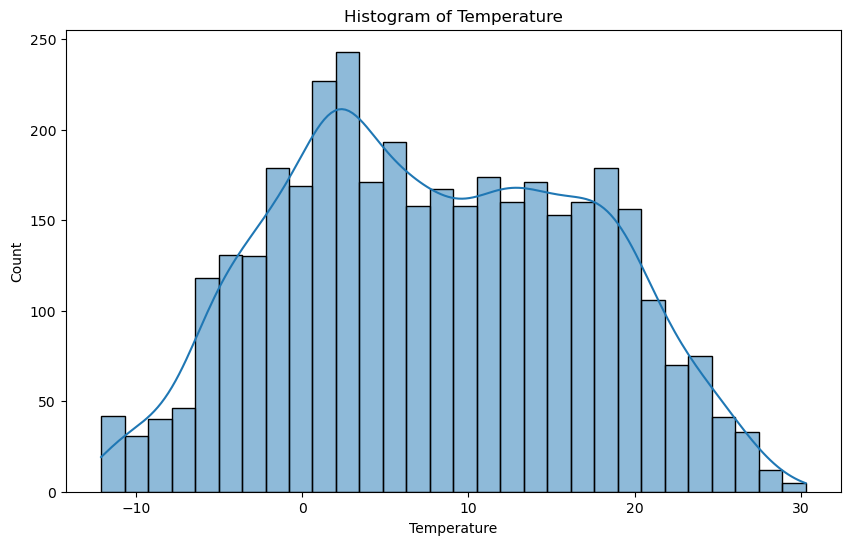

count    3698.000000
mean        7.908518
std         9.148441
min       -12.100000
25%         1.000000
50%         7.400000
75%        15.275000
max        30.300000
Name: Temperature, dtype: float64

In [14]:
# target 변수 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(df['Temperature'], bins=30, kde=True)
plt.title('Histogram of Temperature')
plt.show()

df['Temperature'].describe()

## Feature Engineering

- Spearman Test
- Kruskal-Wallis Test
- Encoding

### Spearman Test

In [15]:
def spearman_test(df, target_col):
    df_numeric = df.select_dtypes(include=['number'])
    features = []
    correlations = []
    p_values = []

    for col in df_numeric.columns:
        if col != target_col:
            corr, p = spearmanr(df_numeric[target_col], df_numeric[col])
            features.append(col)
            correlations.append(corr)
            p_values.append(p)

    corr_df = pd.DataFrame({
        'Feature': features,
        'Correlation': correlations,
        'P-value': p_values}).sort_values(by='Correlation', ascending=False).reset_index(drop=True)

    return corr_df

# heat_map
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

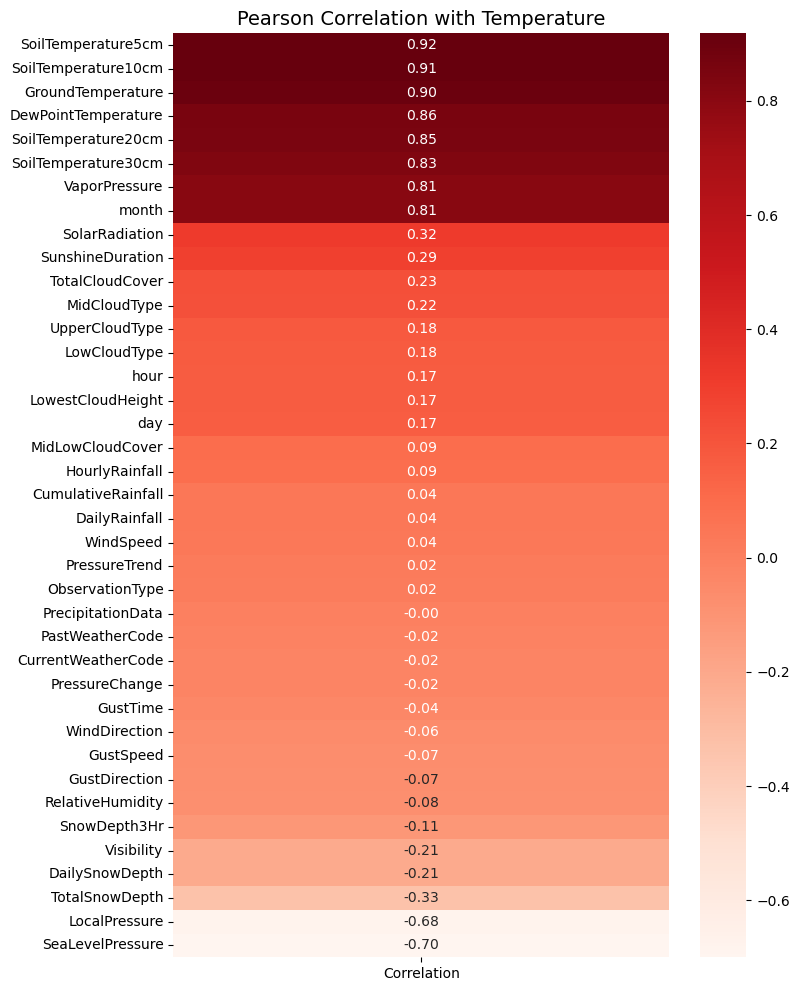

유의미하지 않은 변수의 수: 8
유의미한 변수의 수: 31


,Feature,Correlation,P-value
20,PressureTrend,0.019834,0.227871
21,CumulativeRainfall,0.004591,0.780155
22,DailyRainfall,0.004591,0.780155
23,CurrentWeatherCode,0.004198,0.798581
24,PastWeatherCode,0.000452,0.978098
25,ObservationType,-0.000364,0.982343
26,PrecipitationData,-0.005638,0.731801
27,PressureChange,-0.026775,0.103528


In [16]:
heat_map(df, target_col='Temperature', figsize=(8, 12))
df_spearman = spearman_test(df, 'Temperature')

p_value_05 = df_spearman[df_spearman['P-value'] >= 0.05]
p_value_over_05 = df_spearman[df_spearman['P-value'] < 0.05]

print(f'유의미하지 않은 변수의 수: {len(p_value_05)}')
print(f'유의미한 변수의 수: {len(p_value_over_05)}')

p_value_05

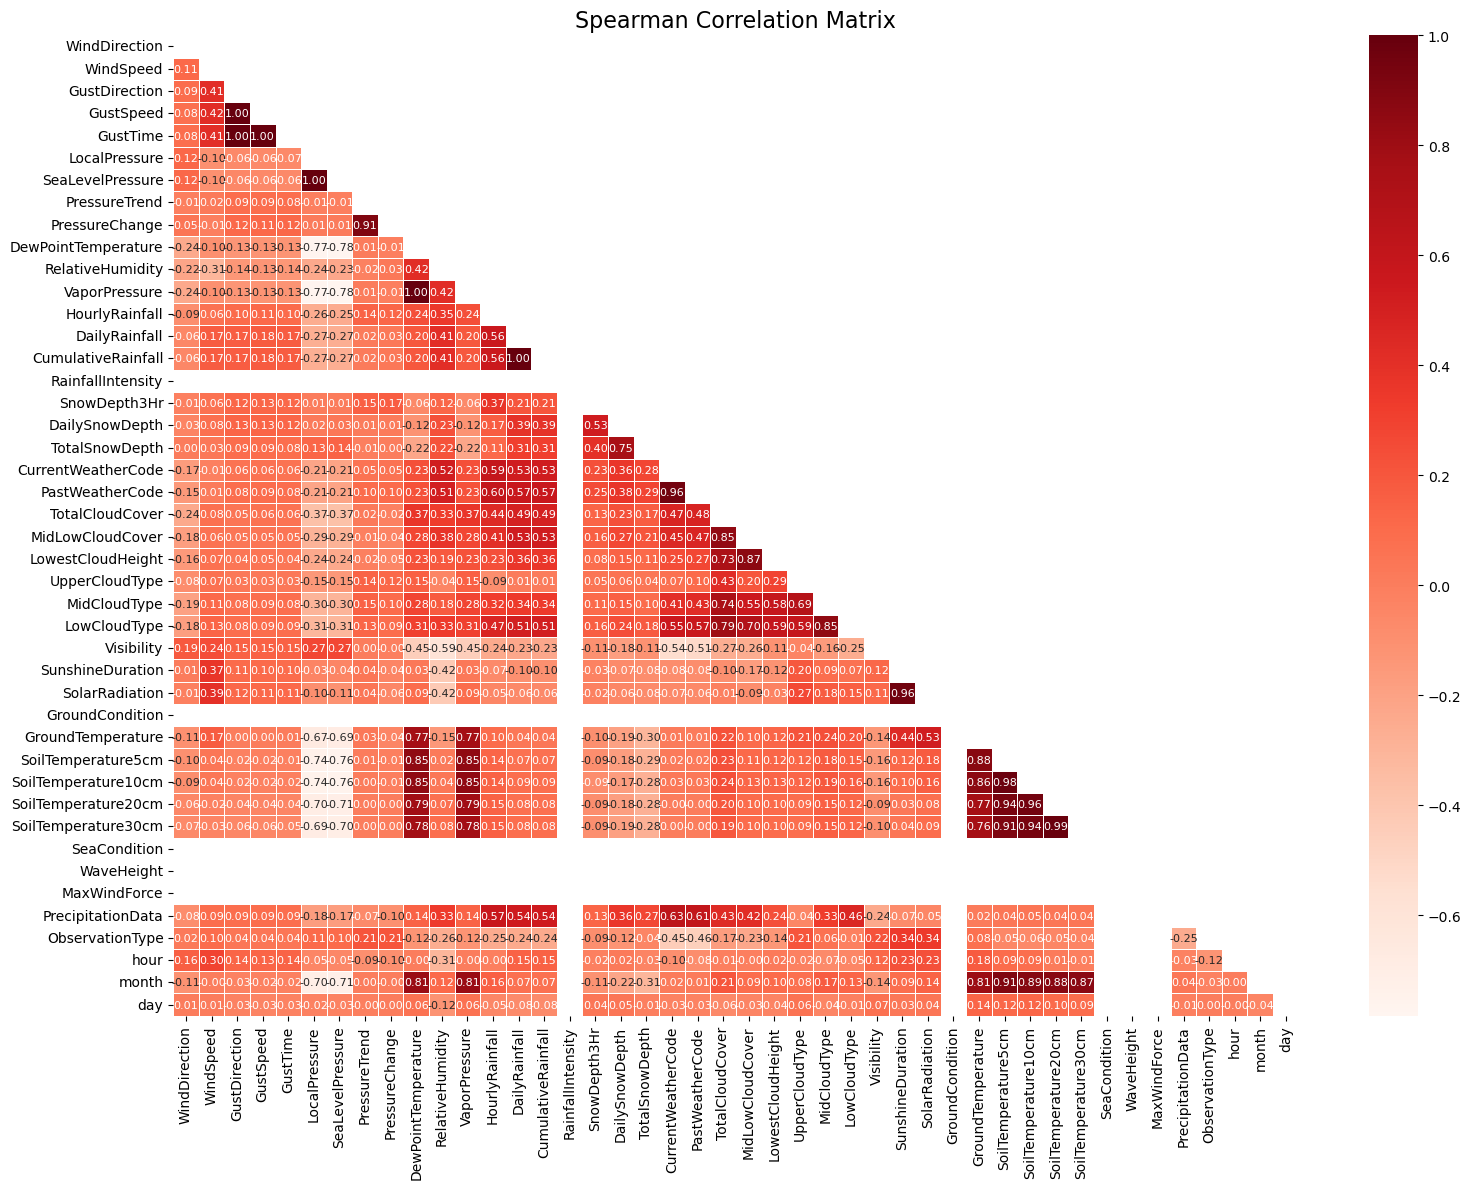

In [17]:
corr = df.select_dtypes(include=['number']).drop(columns=['Temperature']).corr(method='spearman')

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Reds', linewidths=0.5, mask=np.triu(corr), annot_kws={'size': 8})
plt.title("Spearman Correlation Matrix", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
def remove_high_corr_target(df, target_col, threshold=0.95, method='spearman'):
    feats = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    corr_feats = df[feats].corr(method=method).abs()
    corr_target = df[feats].corrwith(df[target_col], method=method).abs()
    
    to_drop = set()
    for i, f1 in enumerate(feats):
        for f2 in feats[i+1:]:
            # 0.95 초과인 경우
            if corr_feats.loc[f1, f2] > threshold:
                if corr_target[f1] >= corr_target[f2]:
                    to_drop.add(f2)
                else:
                    to_drop.add(f1)
    return list(to_drop)

In [19]:
corr_drop_cols = remove_high_corr_target(df, target_col='Temperature', threshold=0.95, method='spearman')
print("제거할 피처 수:", len(corr_drop_cols))
print("제거할 피처:", corr_drop_cols)

제거할 피처 수: 10
제거할 피처: ['SoilTemperature20cm', 'DewPointTemperature', 'SoilTemperature30cm', 'PastWeatherCode', 'SunshineDuration', 'CumulativeRainfall', 'GustSpeed', 'GustTime', 'SoilTemperature10cm', 'LocalPressure']


In [20]:
# 유의미하지 않은 변수 제거
p_value_05_cols = p_value_05['Feature'].tolist()
if 'day' in p_value_05_cols:
    p_value_05_cols.remove('day') # day 는 보존

drop_cols = p_value_05_cols + corr_drop_cols
df = df.drop(columns=drop_cols)
df

,ObservationTime,StationID,WindDirection,WindSpeed,GustDirection,SeaLevelPressure,Temperature,RelativeHumidity,VaporPressure,HourlyRainfall,...,GroundCondition,GroundTemperature,SoilTemperature5cm,SeaCondition,WaveHeight,MaxWindForce,hour,year,month,day
0,2025-01-01 00:00:00,108,29,0.7,-9,1022.5,-1.2,60.0,3.4,-9.0,...,-9,-3.0,-0.3,-9,-9.0,-9,0,2025,1,1
1,2025-01-01 01:00:00,108,25,1.1,-9,1022.6,-1.7,62.0,3.3,-9.0,...,-9,-3.3,-0.3,-9,-9.0,-9,1,2025,1,1
2,2025-01-01 02:00:00,108,34,0.5,-9,1022.4,-1.8,64.0,3.4,-9.0,...,-9,-3.5,-0.3,-9,-9.0,-9,2,2025,1,1
3,2025-01-01 03:00:00,108,2,1.9,-9,1022.2,-2.0,66.0,3.5,-9.0,...,-9,-3.6,-0.3,-9,-9.0,-9,3,2025,1,1
4,2025-01-01 04:00:00,108,2,2.2,-9,1021.7,-2.3,67.0,3.5,-9.0,...,-9,-3.7,-0.3,-9,-9.0,-9,4,2025,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,2025-06-03 21:00:00,108,25,2.3,23,1000.4,19.2,41.0,9.1,-9.0,...,-9,17.2,23.1,-9,-9.0,-9,21,2025,6,3
3694,2025-06-03 22:00:00,108,25,1.9,-9,1001.1,18.3,53.0,11.1,-9.0,...,-9,16.0,22.2,-9,-9.0,-9,22,2025,6,3
3695,2025-06-03 23:00:00,108,27,2.3,-9,1001.3,17.5,60.0,11.9,-9.0,...,-9,15.4,21.7,-9,-9.0,-9,23,2025,6,3
3696,2025-06-04 23:00:00,108,25,2.6,-9,1008.1,19.2,58.0,12.9,-9.0,...,-9,16.4,21.8,-9,-9.0,-9,23,2025,6,4


### Kruskal-Wallis Test

In [21]:
def kruskal_test(df, target_col, min_group_size=5):
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    results = []

    for col in cat_cols:
        grouped = df.groupby(col)[target_col]
        valid_groups = [grp.values for _, grp in grouped if grp.size >= min_group_size]
        if len(valid_groups) >= 2:
            stat, p = kruskal(*valid_groups)
            results.append({'feature': col, 'H-statistic': stat, 'p-value': p})

    return pd.DataFrame(results).sort_values('p-value').reset_index(drop=True)

In [22]:
kruskal_df = kruskal_test(df, 'Temperature')
kruskal_df

,feature,H-statistic,p-value
0,CloudType,406.509743,5.387548e-78
1,WeatherCode,351.284334,1.131905e-65


In [23]:
# 날씨 코드 'WeatherCode', 지점번호 'StationID', 관측시간 'ObservationTime' 제거
df = df.drop(columns=['WeatherCode', 'StationID', 'ObservationTime'])

# 컬럼 순서 변경
df = df[['year', 'month', 'day', 'hour', 'Temperature'] + [c for c in df if c not in ['year', 'month', 'day', 'hour', 'Temperature']]]
df

,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,SeaLevelPressure,RelativeHumidity,...,MidCloudType,LowCloudType,Visibility,SolarRadiation,GroundCondition,GroundTemperature,SoilTemperature5cm,SeaCondition,WaveHeight,MaxWindForce
0,2025,1,1,0,-1.2,29,0.7,-9,1022.5,60.0,...,-9,-9,3546,-9.0,-9,-3.0,-0.3,-9,-9.0,-9
1,2025,1,1,1,-1.7,25,1.1,-9,1022.6,62.0,...,-9,-9,3274,-9.0,-9,-3.3,-0.3,-9,-9.0,-9
2,2025,1,1,2,-1.8,34,0.5,-9,1022.4,64.0,...,-9,-9,3460,-9.0,-9,-3.5,-0.3,-9,-9.0,-9
3,2025,1,1,3,-2.0,2,1.9,-9,1022.2,66.0,...,-9,-9,3256,-9.0,-9,-3.6,-0.3,-9,-9.0,-9
4,2025,1,1,4,-2.3,2,2.2,-9,1021.7,67.0,...,-9,-9,3111,-9.0,-9,-3.7,-0.3,-9,-9.0,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,2025,6,3,21,19.2,25,2.3,23,1000.4,41.0,...,-9,-9,3802,-9.0,-9,17.2,23.1,-9,-9.0,-9
3694,2025,6,3,22,18.3,25,1.9,-9,1001.1,53.0,...,-9,-9,3251,-9.0,-9,16.0,22.2,-9,-9.0,-9
3695,2025,6,3,23,17.5,27,2.3,-9,1001.3,60.0,...,-9,-9,3241,-9.0,-9,15.4,21.7,-9,-9.0,-9
3696,2025,6,4,23,19.2,25,2.6,-9,1008.1,58.0,...,-9,-9,3569,-9.0,-9,16.4,21.8,-9,-9.0,-9


In [24]:
def add_feature(df):
    # season
    df['season'] = df['month'].apply(lambda x:
        'Spring' if 3 <= x <= 5 else
        'Summer' if 6 <= x <= 8 else
        'Fall' if 9 <= x <= 11 else 'Winter')
    
    # time_segment
    df['time_segment'] = df['hour'].apply(lambda x: 
        'Dawn' if 0 <= x < 6 else
        'Morning' if 6 <= x < 12 else
        'Afternoon' if 12 <= x < 18 else
        'Evening' if 18 <= x < 22 else
        'Night')
    
    return df

df = add_feature(df)
df.head()

,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,SeaLevelPressure,RelativeHumidity,...,Visibility,SolarRadiation,GroundCondition,GroundTemperature,SoilTemperature5cm,SeaCondition,WaveHeight,MaxWindForce,season,time_segment
0,2025,1,1,0,-1.2,29,0.7,-9,1022.5,60.0,...,3546,-9.0,-9,-3.0,-0.3,-9,-9.0,-9,Winter,Dawn
1,2025,1,1,1,-1.7,25,1.1,-9,1022.6,62.0,...,3274,-9.0,-9,-3.3,-0.3,-9,-9.0,-9,Winter,Dawn
2,2025,1,1,2,-1.8,34,0.5,-9,1022.4,64.0,...,3460,-9.0,-9,-3.5,-0.3,-9,-9.0,-9,Winter,Dawn
3,2025,1,1,3,-2.0,2,1.9,-9,1022.2,66.0,...,3256,-9.0,-9,-3.6,-0.3,-9,-9.0,-9,Winter,Dawn
4,2025,1,1,4,-2.3,2,2.2,-9,1021.7,67.0,...,3111,-9.0,-9,-3.7,-0.3,-9,-9.0,-9,Winter,Dawn


In [25]:
str_df, num_df = check_dtype(df ,return_data=True)

for col in str_df.columns:
    print(f"{col}의 유니크 수: {str_df[col].nunique()}")

Object Data Type: 3
Number Data Type: 29
CloudType의 유니크 수: 21
season의 유니크 수: 3
time_segment의 유니크 수: 5


### Split Data

In [26]:
# 시간 순으로 정렬
df = df.sort_values(by=['year', 'month', 'day', 'hour']).reset_index(drop=True)

# test data
test_hours = 24  # 24시간
test_df = df.iloc[-test_hours:].copy()

# train/val 분리
remain_df = df.iloc[:-test_hours].copy()
n = len(remain_df)
train_ratio = 0.8 
train_size = int(n * train_ratio)

train_df = remain_df.iloc[:train_size].copy()
val_df = remain_df.iloc[train_size:].copy()

print(f"train_df: {train_df.shape}")
print(f"val_df: {val_df.shape}")
print(f"test_df: {test_df.shape}")

test_df

train_df: (2939, 33)
val_df: (735, 33)
test_df: (24, 33)


,year,month,day,hour,Temperature,WindDirection,WindSpeed,GustDirection,SeaLevelPressure,RelativeHumidity,...,Visibility,SolarRadiation,GroundCondition,GroundTemperature,SoilTemperature5cm,SeaCondition,WaveHeight,MaxWindForce,season,time_segment
3674,2025,6,3,2,19.9,27,0.9,-9,999.0,73.0,...,828,-9.00,-9,18.6,20.5,-9,-9.0,-9,Summer,Dawn
3675,2025,6,3,3,19.7,29,2.0,-9,999.1,71.0,...,994,-9.00,-9,18.4,20.4,-9,-9.0,-9,Summer,Dawn
3676,2025,6,3,4,19.3,25,0.7,-9,998.9,73.0,...,916,-9.00,-9,17.9,20.4,-9,-9.0,-9,Summer,Dawn
3677,2025,6,3,5,18.6,27,1.7,-9,999.2,77.0,...,834,-9.00,-9,16.2,19.9,-9,-9.0,-9,Summer,Dawn
3678,2025,6,3,6,18.0,27,1.3,-9,999.2,79.0,...,708,0.06,-9,16.0,19.6,-9,-9.0,-9,Summer,Morning
3679,2025,6,3,7,18.6,27,1.8,-9,999.4,80.0,...,762,0.43,-9,18.6,19.4,-9,-9.0,-9,Summer,Morning
3680,2025,6,3,8,20.0,29,3.1,-9,999.3,63.0,...,1298,1.19,-9,26.5,20.1,-9,-9.0,-9,Summer,Morning
3681,2025,6,3,9,21.4,29,2.0,-9,998.8,55.0,...,1686,1.98,-9,35.1,20.9,-9,-9.0,-9,Summer,Morning
3682,2025,6,3,10,23.0,25,2.5,-9,998.6,52.0,...,1553,2.60,-9,43.5,22.0,-9,-9.0,-9,Summer,Morning
3683,2025,6,3,11,24.2,25,3.5,-9,998.2,44.0,...,1810,3.16,-9,49.0,23.3,-9,-9.0,-9,Summer,Morning


### Encoding

In [27]:
train = train_df.copy()
val = val_df.copy()
test = test_df.copy()
str_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

label_cols = []
onehot_cols = []

for col in str_cols:
    unique_vals = train[col].nunique()
    if unique_vals <= 10:
        onehot_cols.append(col)
    else:
        label_cols.append(col)

label_encoders = {}
onehot_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

    val[col] = val[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    test[col] = test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

for col in onehot_cols:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    train_arr = ohe.fit_transform(train[[col]])
    ohe_cols = ohe.get_feature_names_out([col])
    train_ohe = pd.DataFrame(train_arr, columns=ohe_cols, index=train.index)
    train.drop(columns=[col], inplace=True)
    train = pd.concat([train, train_ohe], axis=1)

    for df_encoded, df_raw in zip([val, test], [val_df, test_df]):
        arr = ohe.transform(df_raw[[col]])
        df_ohe = pd.DataFrame(arr, columns=ohe_cols, index=df_encoded.index)
        df_encoded.drop(columns=[col], inplace=True)
        df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

        if df_encoded is val:
            val = df_encoded
        else:
            test = df_encoded

    onehot_encoders[col] = ohe

feature_cols = sorted([col for col in train.columns if col != 'Temperature'])

for df in [val, test]:
    for col in feature_cols:
        if col not in df.columns:
            df[col] = 0
    extra_cols = [col for col in df.columns if col not in feature_cols + ['Temperature']]
    df.drop(columns=extra_cols, inplace=True)
    df = df[feature_cols + ['Temperature']]
    if df is val:
        val = df
    else:
        test = df

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"test: {test.shape}")

train: (2939, 38)
val: (735, 38)
test: (24, 38)


## Models

In [28]:
X_train = train.drop(columns=['Temperature'])
y_train = train['Temperature']
X_val = val.drop(columns=['Temperature'])
y_val = val['Temperature']

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

X_train: (2939, 37)
y_train: (2939,)
X_val: (735, 37)
y_val: (735,)


In [29]:
def check_column_order(X_train, X_val, X_train_name='X_train', X_val_name='X_val'):
    if X_train.columns.tolist() == X_val.columns.tolist():
        print(f"{X_train_name}과 {X_val_name}의 컬럼 및 순서가 모두 일치")
    else:
        print(f"{X_train_name}과 {X_val_name}의 컬럼 또는 순서 불일치")

        train_cols_set = set(X_train.columns)
        val_cols_set = set(X_val.columns)

        only_in_train = list(train_cols_set - val_cols_set)
        only_in_val = list(val_cols_set - train_cols_set)

        if only_in_train or only_in_val:
            print("컬럼 이름 불일치:")
            print(f"{X_train_name}에만 있는 컬럼:", only_in_train)
            print(f"{X_val_name}에만 있는 컬럼:", only_in_val)
        else:
            print("컬럼 이름은 동일하나 순서가 다름\n")

            for i, (col_train, col_val) in enumerate(zip(X_train.columns, X_val.columns)):
                if col_train != col_val:
                    print(f"{i}번째 컬럼 순서 불일치: {X_train_name} = {col_train}, {X_val_name} = {col_val}")

check_column_order(X_train, X_val, 'X_train', 'X_val')

X_train과 X_val의 컬럼 또는 순서 불일치
컬럼 이름은 동일하나 순서가 다름

29번째 컬럼 순서 불일치: X_train = year_2025, X_val = season_Spring
30번째 컬럼 순서 불일치: X_train = season_Spring, X_val = season_Winter
31번째 컬럼 순서 불일치: X_train = season_Winter, X_val = time_segment_Afternoon
32번째 컬럼 순서 불일치: X_train = time_segment_Afternoon, X_val = time_segment_Dawn
33번째 컬럼 순서 불일치: X_train = time_segment_Dawn, X_val = time_segment_Evening
34번째 컬럼 순서 불일치: X_train = time_segment_Evening, X_val = time_segment_Morning
35번째 컬럼 순서 불일치: X_train = time_segment_Morning, X_val = time_segment_Night
36번째 컬럼 순서 불일치: X_train = time_segment_Night, X_val = year_2025


In [31]:
# 컬럼 순서 통일
X_val = X_val[X_train.columns]
test = test[X_train.columns]

check_column_order(X_train, X_val, 'X_train', 'X_val')
check_column_order(X_train, test, 'X_train', 'test')

X_train과 X_val의 컬럼 및 순서가 모두 일치
X_train과 test의 컬럼 및 순서가 모두 일치


In [32]:
def select_models(X_train, X_val, y_train, y_val):
    tmp_dir = tempfile.mkdtemp()  # 임시 디렉토리 생성

    models = {
        "LightGBM": LGBMRegressor(
            n_estimators=1000, 
            learning_rate=0.05, 
            max_depth=10, 
            subsample=0.8, 
            colsample_bytree=0.8,
            random_state=42, 
            n_jobs=-1, 
            verbose=-1
        ),
        "RandomForest": RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose=0
        ),
        "ExtraTrees": ExtraTreesRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose=0
        ),
        "XGBoost": XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ),
        "CatBoost": CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=10,
            l2_leaf_reg=3,
            bagging_temperature=1,
            random_strength=1,
            thread_count=-1,
            random_state=42,
            verbose=False,
            train_dir=tmp_dir  # catboost_info 폴더 생성 방지
        )
    }

    results = []
    trained_models = {}
    total = len(models)

    for idx, (name, model) in enumerate(models.items(), start=1):
        print(f"[{idx}/{total}] Training model: {name} ...")

        start_time = time.time()  # 학습 시작 시간 기록
        model.fit(X_train, y_train)
        end_time = time.time()  # 학습 종료 시간 기록
        training_time = round(end_time - start_time, 2)  # 학습 시간 계산

        y_pred = model.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred, squared=False)

        results.append({
            "model": name,
            "RMSE": rmse,
            "Training_Time": training_time})  # 학습 시간 추가

        trained_models[name] = model  # 모델 저장

    metrics_df = pd.DataFrame(results)
    metrics_df = metrics_df.sort_values("RMSE", ascending=True).reset_index(drop=True)

    return metrics_df, trained_models

In [33]:
metrics_df, models = select_models(X_train, X_val, y_train, y_val)
metrics_df

[1/5] Training model: LightGBM ...
[2/5] Training model: RandomForest ...
[3/5] Training model: ExtraTrees ...
[4/5] Training model: XGBoost ...
[5/5] Training model: CatBoost ...


,model,RMSE,Training_Time
0,LightGBM,1.648200,3.29
1,XGBoost,1.668223,3.02
2,CatBoost,3.450252,8.42
3,RandomForest,4.135316,0.40
4,ExtraTrees,5.297585,0.23


In [ ]:
# best model 추론
models['LightGBM'].predict(test)